In [1]:
using FluPredictibility, FluPredictibility.BioTools, FluPredictibility.TreeTools
using Plots
using StatsBase, Dates, Measures, DataStructures, LaTeXStrings, DelimitedFiles
Flu = FluPredictibility
pyplot();

In [2]:
# Input data
aln_ha_aa = "../alignments/aligned_h3n2_ha_aa.fasta"
aln_na_aa = "../alignments/aligned_h3n2_na_aa.fasta"

# Time binning
binwidth = Day(30);
binspacing = Day(30);
startdate = Date(2000) 
startdate_h1n1pdm = Date(2009,06); 

In [3]:
# For plots
base= 18
lfs = base # Legend font size
alfs = base # axis label font size
tfs = base # title font size
atfs = base # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1280,960) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
annfs = 38
#
saveplots = true
(sf_main, sf_SM) = readdlm("../savefolders.txt")

2×1 Array{Any,2}:
 "/home/pierrebc/Documents/BaleLabo/Notes/FluPredictibility/Article/Figures"
 "/home/pierrebc/Documents/BaleLabo/Notes/FluPredictibility/Article/SM_figures"

In [29]:
function get_trajectories(ph, f0; v=false, keep_unfinished=true)
    trajectories = Flu.all_trajectories(ph, keep_unfinished=keep_unfinished)
    trajectories = Flu.previous_state_condition(trajectories, :lost)
    trajectories = Flu.population_size_condition(trajectories, 10);
    trajectories = Flu.frequency_condition(trajectories, f0);
    v && println("Found $(length(trajectories)) trajectories")
    return trajectories
end

get_trajectories (generic function with 1 method)

# First, the main text figure for h3n2

In [5]:
fp_h3n2_ha = Flu.FluPop(aln_ha_aa, :aa, Flu.flu_usual_header_fields, 
    flulineage="h3n2", segment="ha", ignore_read_errors=true);
fp_h3n2_na = Flu.FluPop(aln_na_aa, :aa, Flu.flu_usual_header_fields, 
    flulineage="h3n2", segment="na", ignore_read_errors=true);

Reading ../alignments/aligned_h3n2_ha_aa.fasta...
Read 44971 strains out of 61848. Filtered 16877. Could not read 0
Reading ../alignments/aligned_h3n2_na_aa.fasta...
Read 36293 strains out of 39312. Filtered 3019. Could not read 0


In [6]:
Flu.bin_by_date!(fp_h3n2_ha, start = startdate, binwidth=binwidth, binspacing = binspacing);
Flu.bin_by_date!(fp_h3n2_na, start = startdate, binwidth=binwidth, binspacing = binspacing);

ph_h3n2_ha = Flu.PosEvo(fp_h3n2_ha);
ph_h3n2_na = Flu.PosEvo(fp_h3n2_na);

## All rising trajectories seen at 30% frequency

In [7]:
f0 = 0.3
traj_h3n2_ha = get_trajectories(ph_h3n2_ha, f0)
traj_h3n2_na = get_trajectories(ph_h3n2_na, f0)

all_trajectories = vcat(traj_h3n2_ha, traj_h3n2_na);

In [8]:
# Computing the average trajectory obtained
meantraj = OrderedDict()
idxt = Day.(-600:30:2250)
idx = 1:96
for traj in all_trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        for i in idx
            t = idxt[i]
            if t < traj.t[1]
                f = 0.
            elseif t > traj.t[end]
                f = traj.fixation == :fixed ? 1. : 0.
            else
                ii = findfirst(x->x==t, traj.t)
                f = traj.freq[ii]
            end
            push!(get!(meantraj, t, Float64[]), f)
        end
    end
end
meantraj = sort(OrderedDict(t=>mean(x) for (t,x) in meantraj));

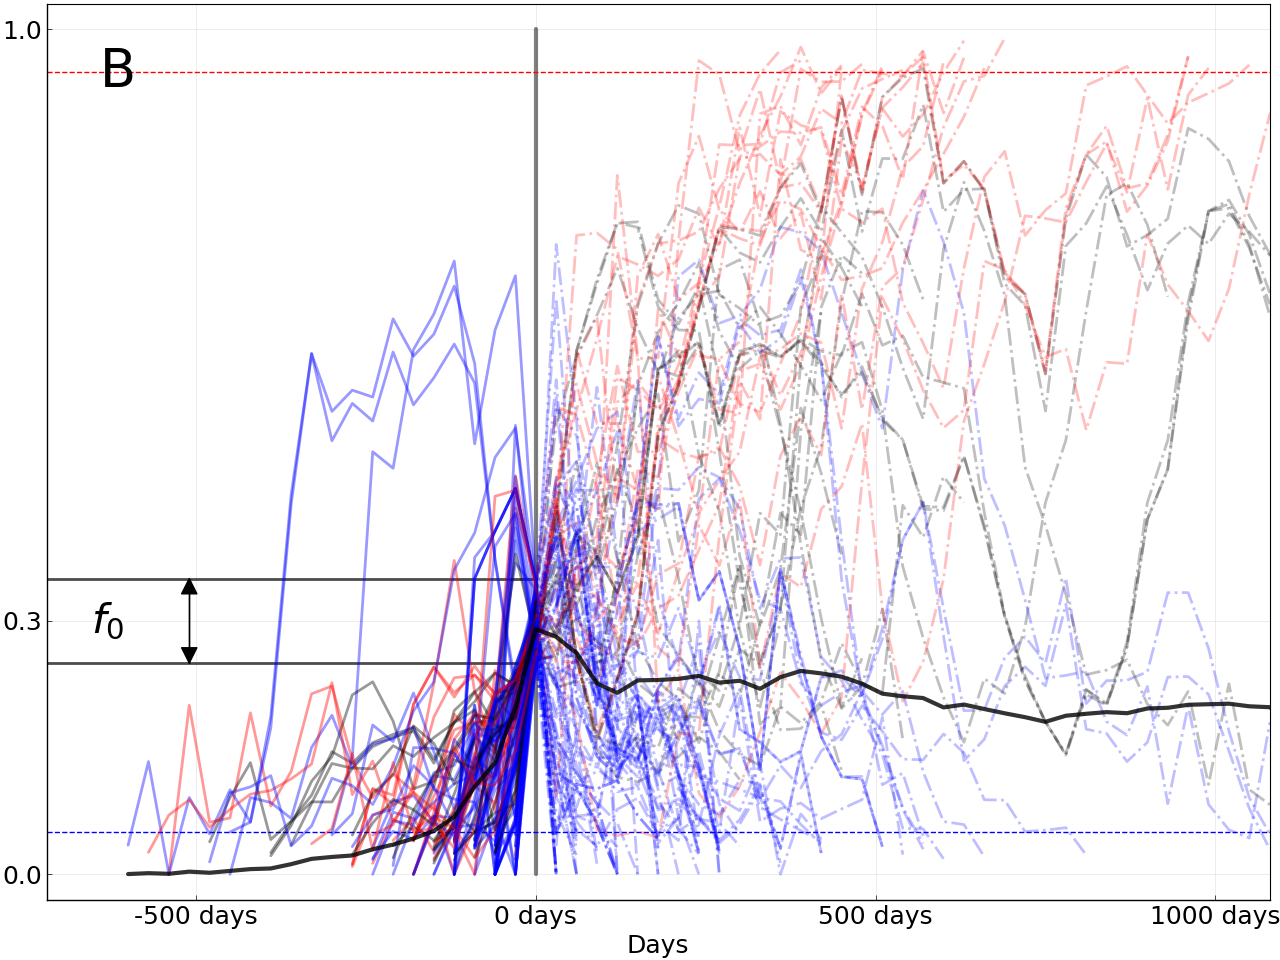

In [9]:
# Plotting cell

# Colors and alpha of curves
αp = 0.4
αf = 0.25
cfixed = :red; clost = :blue; cother = :black
lw = 2
# Used for legends
lostflag= false
fixedflag = false
otherflag = false
#
p = plot()
# Time = 0 line
plot!(p, [0, 0], [0, 1.], line=(3, :black), label="", alpha=0.5)
# Fixation and loss lines
plot!(p, [-24*30, 36*30], [0.95, 0.95], line=(:red, :dash), label="")
plot!(p, [-24*30, 36*30], [0.05, 0.05], line=(:blue, :dash), label="")
#Frequency bin
plot!(p, [-24*30, 0], [0.25, 0.25], line=(:black, 2, 0.7), label="")
plot!(p, [-24*30, 0], [0.35, 0.35], line=(:black, 2, 0.7), label="")
# Arrows
plot!(p, [-17*30, -17*30], [0.25,0.35], arrow=1.1, color=:black, label="")
plot!(p, [-17*30, -17*30], [0.35,0.25], arrow=1.1, color=:black, label="")
plot!(p, ann=(-21*30, 0.3, text(L"f_0", 30)))

# Trajectories
for traj in all_trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        istart = traj.index[:start]; iend = traj.index[:end]; iact = traj.index[:active]
        if traj.fixation==:lost
            lab = lostflag ? "" : ""
            lostflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=clost, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=clost, line=(lw, :dashdot))
        elseif traj.fixation==:fixed
            lab = fixedflag ? "" : ""
            fixedflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=cfixed, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=cfixed, line=(lw, :dashdot))
        else
            lab = otherflag ? "" : ""
            otherflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=cother, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=cother, line=(lw, :dashdot))
        end
    end
end
plot!(collect(keys(meantraj)), collect(values(meantraj)), label="", line=(3, :black, 0.8))
plot!(p, size=(1280, 960), frame=:box)
plot!(p, guidefontsize=atfs, tickfontsize= atfs, legendfontsize = 22)
plot!(xlabel="Days", ylabel="")
plot!(p, xlim=(-24*30,30*36))
plot!(p, yticks = [0., 0.3, 1.])
plot!(p, ann = (-20.5*30, 0.95, text("B",annfs)))
p2_sb2 = p;
p

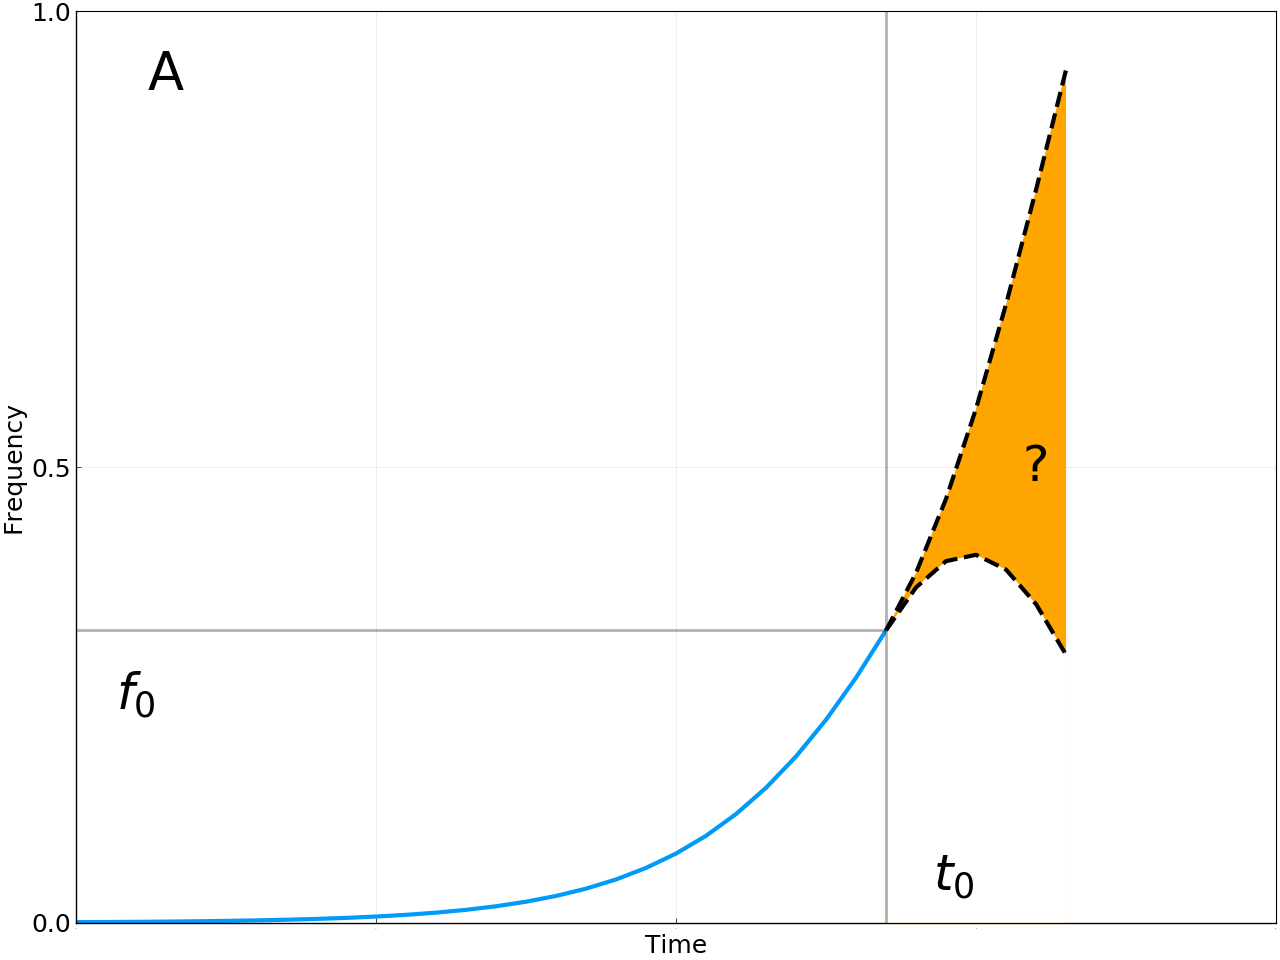

In [11]:
ff(x,xe) = exp(x/xe) / (1+exp(x/xe)) 
gg(x) = x^2/2
X = -30:-3
Y = ff.(X,4)
x2 = -3:3
#
p = plot()
plot!(X,Y,ylim=(0,1),xlim=(-30,10), size=(640,640), label="", linewidth=3)
plot!(p, x2, 2*(ff.(x2,4) .- Y[end]).^2 + ff.(x2,4), line=(3,:dash, :black), label="",fill=(0,:orange))
plot!(p, x2, -3*(ff.(x2,4) .- Y[end]).^2 + ff.(x2,4), line=(3,:dash, :black), label="", fill=(0,:white))
plot!(p,[-3,-3], [0,1], line=(2, :black),label="", alpha=0.3)
plot!(p, [-30, -3], [ff(-3,4), ff(-3,4)], label="", line=(2,:black,0.3))
plot!(guidefontsize=alfs, tickfontsize=tfs)
plot!(yticks = [0., 0.5, 1.])
plot!(ann = (2., 0.5, text("?",36)))
plot!(ann = [(-28, 0.25, text(L"f_0",36)), (-0.75, 0.05, text(L"t_0",36))] )
plot!(ann = (-27, 0.93, text("A",annfs)))
plot!(p, xtickfontsize=0, xlabel="Time",ylabel="Frequency", frame=:box)
p2_sb1 = p;
plot!(p, size=(1280,960))

## Histograms

In [12]:
dat = Dict()
for traj in all_trajectories
    is = traj.index[:active]
    ie = is+48
    for i in is:ie
        if i > length(traj.t)
            t = (i-is)*binspacing.value
            traj.fixation != :poly && push!(get!(dat,t,Float64[]), traj.fixation==:fixed ? 1. : 0.)
        else
            push!(get!(dat,traj.t[i].value,Float64[]), traj.freq[i])
        end
    end
end

In [13]:
pb = []
bins = collect(-1e-6:0.200001:1.00001)
# xs = vcat(0., collect(0.05:0.15:0.8) .+ 0.1, 1.)

tvalues = [0,30,60,120,360,720]
for (i,t) in enumerate(tvalues)
    h = fit(Histogram, dat[t], bins)
    y = h.weights/sum(h.weights)
    # Plot
    p = histogram(dat[t], bins=bins,label="$t days", normalized=:probability)
    plot!(p, size=(1000,200), ylim=(-0.07,1.08), xlim=(-0.05,1.05), yticks=[0.,0.5,1.], legendfontsize=lfs)
    plot!(p, xticks=collect(0.1:0.2:0.9), tickfontsize=tfs, guidefontsize=alfs)
    #
    if i == length(tvalues) || i == div(length(tvalues),2)
        plot!(p, xlabel="Frequency of mutation", guidefontsize=alfs, xtickfontsize=tfs)
    else
        plot!(p, xlabelfontsize=0, xtickfontsize=0)
    end
    if t == 0 
        plot!(p, ann=(0.02, 1.25, text("C",annfs)))
    end
    push!(pb, p)
end

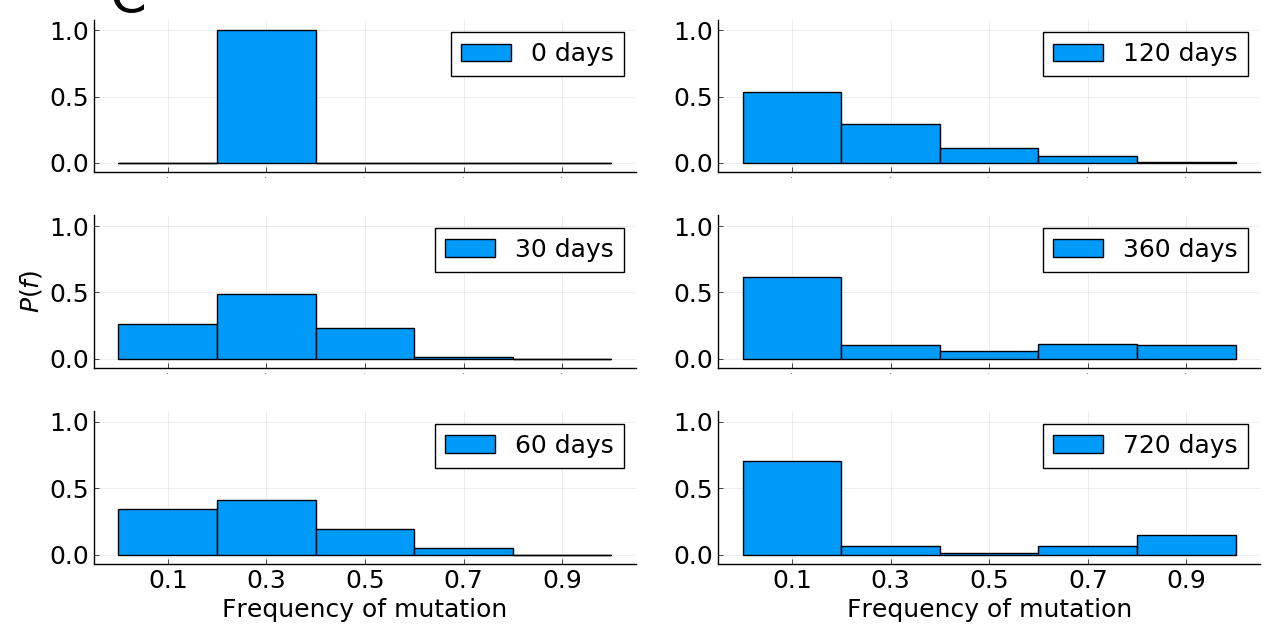

In [14]:
p_st_1 = plot(pb[1:3]..., ylabel=["" L"P(f)" ""], layout=(div(length(pb),2),1), size=(640,640), margin = 5mm, guidefontsize = atfs)
p_st_2 = plot(pb[4:6]..., ylabel=["" "" ""], layout=(div(length(pb),2),1), size=(640,480), margin=5mm)
p2_sb3 = plot(p_st_1, p_st_2, layout=grid(1,2), size=(1280, 640))


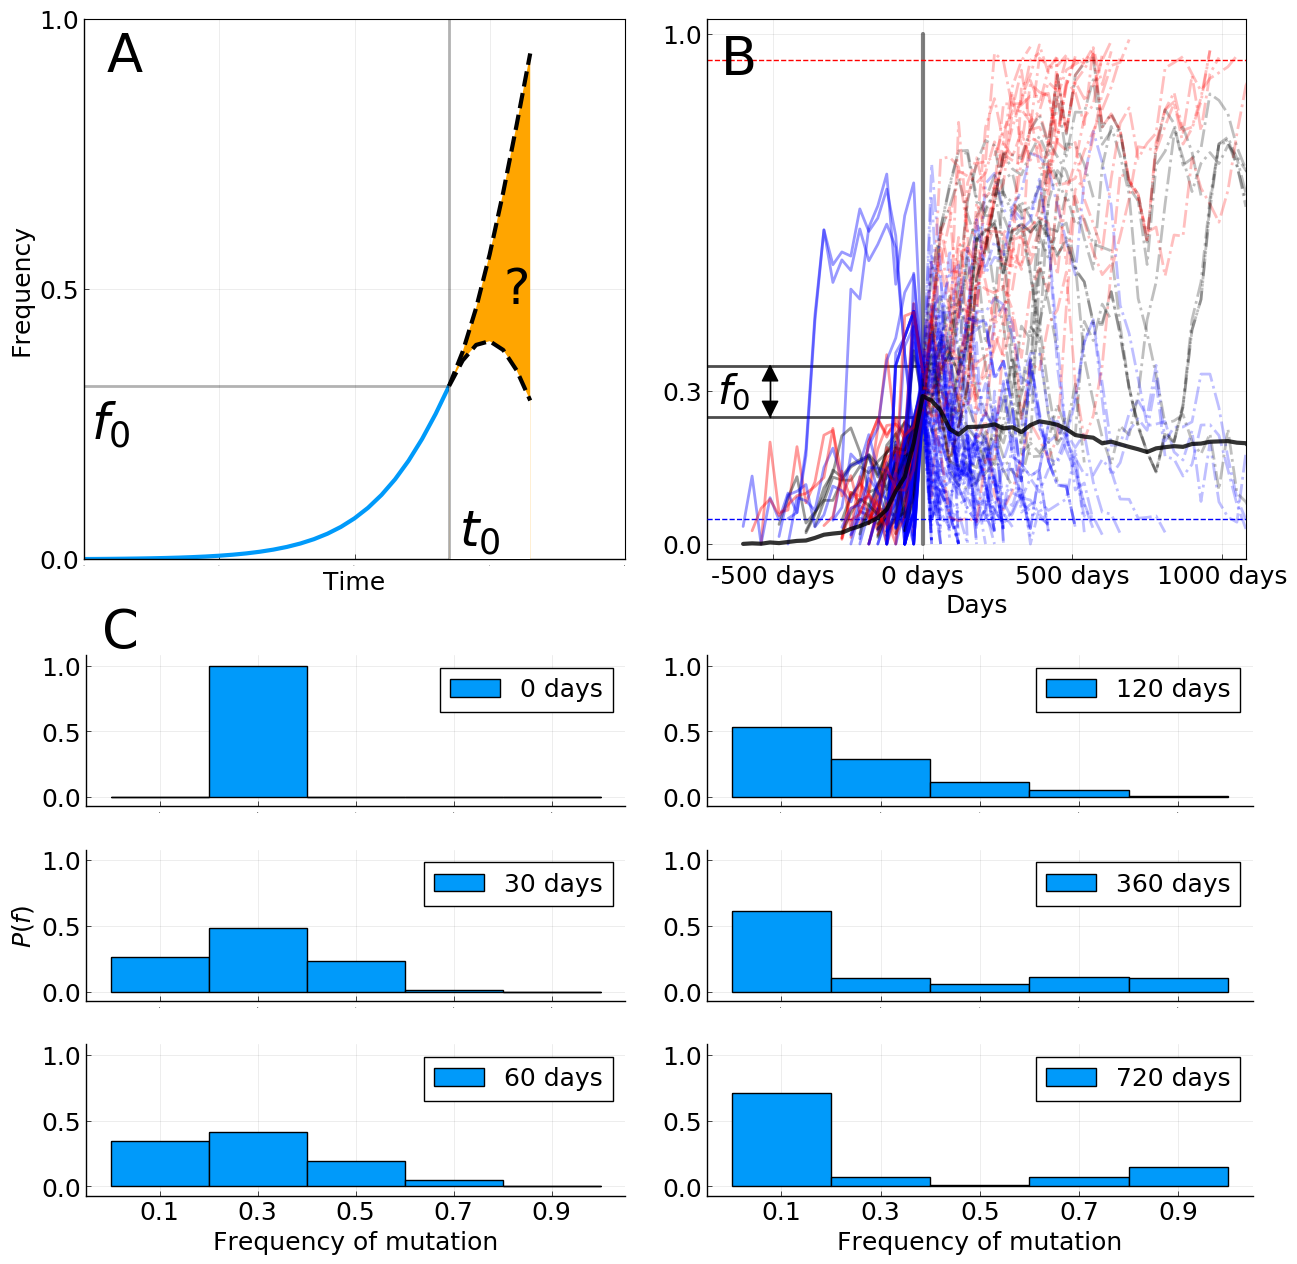

In [15]:
tmp = plot(p2_sb1, p2_sb2, layout=grid(1,2), size=(1280,640), right_margin=5.1mm)
p2 = plot(tmp, p2_sb3, layout = grid(2,1), size=(1280,1280), margin = 5mm)
saveplots && savefig("$(sf_main)/Panel1.png")

# Figure for h1n1

In [16]:
aln_ha_aa = "../alignments/aligned_h1n1pdm_ha_aa.fasta"
aln_na_aa = "../alignments/aligned_h1n1pdm_na_aa.fasta";

In [17]:
fp_h1n1_ha = Flu.FluPop(aln_ha_aa, :aa, Flu.flu_usual_header_fields, 
    flulineage="h1n1pdm", segment="ha", ignore_read_errors=true);
fp_h1n1_na = Flu.FluPop(aln_na_aa, :aa, Flu.flu_usual_header_fields, 
    flulineage="h1n1pdm", segment="na", ignore_read_errors=true);

Reading ../alignments/aligned_h1n1pdm_ha_aa.fasta...
Read 45350 strains out of 54146. Filtered 8796. Could not read 0
Reading ../alignments/aligned_h1n1pdm_na_aa.fasta...
Read 40412 strains out of 42854. Filtered 2442. Could not read 0


In [24]:
Flu.bin_by_date!(fp_h1n1_ha, start = startdate_h1n1pdm, binwidth=binwidth, binspacing = binspacing);
Flu.bin_by_date!(fp_h1n1_na, start = startdate_h1n1pdm, binwidth=binwidth, binspacing = binspacing);

ph_h1n1_ha = Flu.PosEvo(fp_h1n1_ha);
ph_h1n1_na = Flu.PosEvo(fp_h1n1_na);

In [25]:
f0 = 0.3
traj_h1n1_ha = get_trajectories(ph_h1n1_ha, f0)
traj_h1n1_na = get_trajectories(ph_h1n1_na, f0)

all_trajectories = vcat(traj_h1n1_ha, traj_h1n1_na);

In [26]:
# Computing the average trajectory obtained
meantraj = OrderedDict()
idxt = Day.(-600:30:2250)
idx = 1:96
for traj in all_trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        for i in idx
            t = idxt[i]
            if t < traj.t[1]
                f = 0.
            elseif t > traj.t[end]
                f = traj.fixation == :fixed ? 1. : 0.
            else
                ii = findfirst(x->x==t, traj.t)
                f = traj.freq[ii]
            end
            push!(get!(meantraj, t, Float64[]), f)
        end
    end
end
meantraj = sort(OrderedDict(t=>mean(x) for (t,x) in meantraj));

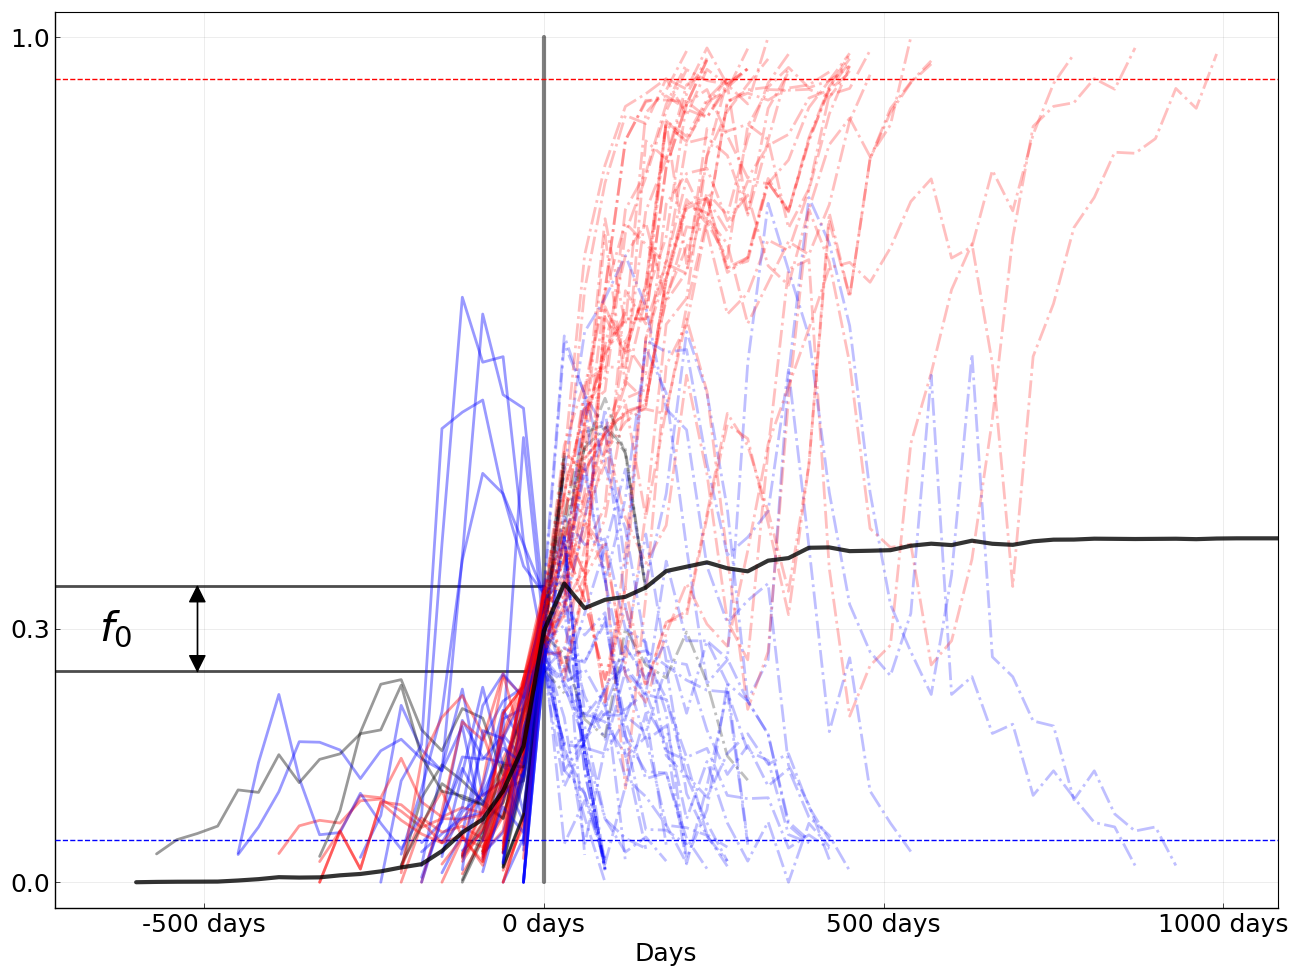

In [27]:
# Plotting cell

# Colors and alpha of curves
αp = 0.4
αf = 0.25
cfixed = :red; clost = :blue; cother = :black
lw = 2
# Used for legends
lostflag= false
fixedflag = false
otherflag = false
#
p = plot()
# Time = 0 line
plot!(p, [0, 0], [0, 1.], line=(3, :black), label="", alpha=0.5)
# Fixation and loss lines
plot!(p, [-24*30, 36*30], [0.95, 0.95], line=(:red, :dash), label="")
plot!(p, [-24*30, 36*30], [0.05, 0.05], line=(:blue, :dash), label="")
#Frequency bin
plot!(p, [-24*30, 0], [0.25, 0.25], line=(:black, 2, 0.7), label="")
plot!(p, [-24*30, 0], [0.35, 0.35], line=(:black, 2, 0.7), label="")
# Arrows
plot!(p, [-17*30, -17*30], [0.25,0.35], arrow=1.1, color=:black, label="")
plot!(p, [-17*30, -17*30], [0.35,0.25], arrow=1.1, color=:black, label="")
plot!(p, ann=(-21*30, 0.3, text(L"f_0", 30)))

# Trajectories
for traj in all_trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        istart = traj.index[:start]; iend = traj.index[:end]; iact = traj.index[:active]
        if traj.fixation==:lost
            lab = lostflag ? "" : ""
            lostflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=clost, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=clost, line=(lw, :dashdot))
        elseif traj.fixation==:fixed
            lab = fixedflag ? "" : ""
            fixedflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=cfixed, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=cfixed, line=(lw, :dashdot))
        else
            lab = otherflag ? "" : ""
            otherflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=cother, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=cother, line=(lw, :dashdot))
        end
    end
end
plot!(collect(keys(meantraj)), collect(values(meantraj)), label="", line=(3, :black, 0.8))
plot!(p, size=(1280, 960), frame=:box)
plot!(p, guidefontsize=atfs, tickfontsize= atfs, legendfontsize = 22)
plot!(xlabel="Days", ylabel="")
plot!(p, xlim=(-24*30,30*36))
plot!(p, yticks = [0., 0.3, 1.])
# plot!(p, ann = (-20.5*30, 0.95, text("B",annfs)))
p2_sb2 = p;
p
saveplots && savefig("$(sf_SM)/ShortTerm_h1n1.png")